# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Linear-Regression-problem" data-toc-modified-id="Linear-Regression-problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Linear Regression problem</a></div><div class="lev1 toc-item"><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gradient Descent</a></div><div class="lev1 toc-item"><a href="#Gradient-Descent---Classification" data-toc-modified-id="Gradient-Descent---Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gradient Descent - Classification</a></div><div class="lev1 toc-item"><a href="#Gradient-descent-with-numpy" data-toc-modified-id="Gradient-descent-with-numpy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Gradient descent with numpy</a></div>

In [1]:
%matplotlib inline
from fastai.learner import *

In this part of the lecture we explain Stochastic Gradient Descent (SGD) which is an **optimization** method commonly used in neural networks. We will illustrate the concepts with concrete examples.

#  Linear Regression problem

The goal of linear regression is to fit a line to a set of points.

In [2]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

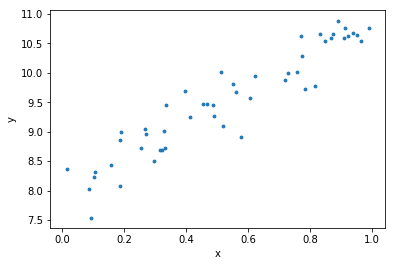

In [3]:
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y"); 

You want to find **parameters** (weights) $a$ and $b$ such that you minimize the *error* between the points and the line $a\cdot x + b$. Note that here $a$ and $b$ are unknown. For a regression problem the most common *error function* or *loss function* is the **mean squared error**. 

In [4]:
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()

Suppose we believe $a = 10$ and $b = 5$ then we can compute `y_hat` which is our *prediction* and then compute our error.

In [5]:
y_hat = lin(10,5,x)
mse(y_hat, y)

5.02718697133799

In [6]:
def mse_loss(a, b, x, y): return mse(lin(a,b,x), y)

In [7]:
mse_loss(10, 5, x, y)

5.02718697133799

So far we have specified the *model* (linear regression) and the *evaluation criteria* (or *loss function*). Now we need to handle *optimization*; that is, how do we find the best values for $a$ and $b$? How do we find the best *fitting* linear regression.

# Gradient Descent

For a fixed dataset $x$ and $y$ `mse_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [8]:
# generate some more data
x, y = gen_fake_data(10000, 3., 8.)
x.shape, y.shape

((10000,), (10000,))

In [9]:
x,y = V(x),V(y)

In [10]:
# Create random weights a and b, and wrap them in Variables.
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)
a,b

(Variable containing:
 -0.4555
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 -0.7605
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [11]:
learning_rate = 1e-3
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    loss = mse_loss(a,b,x,y)
    if t % 1000 == 0: print(loss.data[0])
    
    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Zero the gradients
    a.grad.data.zero_()
    b.grad.data.zero_()    

111.21234130859375
0.8398099541664124
0.14161360263824463
0.12662610411643982
0.11832382529973984
0.11194991320371628
0.10704084485769272
0.10325983911752701
0.10034767538309097
0.09810474514961243


Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

# Gradient Descent - Classification

For a fixed dataset $x$ and $y$ `mse_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [12]:
def gen_fake_data2(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, np.where(y>10, 1, 0).astype(np.float32)

In [13]:
x,y = gen_fake_data2(10000, 3., 8.)
x,y = V(x),V(y)

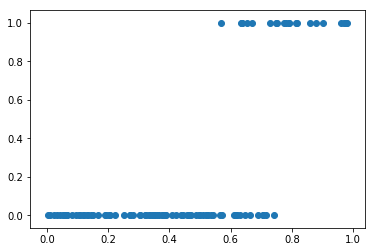

In [14]:
plt.scatter(to_np(x)[:100], to_np(y)[:100])

In [20]:
print((to_np(y) == 1).sum(), (to_np(y) == 0).sum())

3406 6594


In [42]:
def nll(y_hat, y): # negative log likelihood loss
    y_hat = torch.clamp(y_hat, 1e-5, 1-1e-5) # Clamp all elements in input into the range[1e-5, 1-1e-5] to avoid log(0)
    return (y*y_hat.log() + (1-y)*(1-y_hat).log()).mean()

In [43]:
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)

In [39]:
a.data, b.data

(
 -0.7470
 [torch.cuda.FloatTensor of size 1 (GPU 0)], 
 -0.7631
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [44]:
learning_rate = 1e-2

#for t in range(3000):
for t in range(30000):    
    # sigmoid
    p = (-lin(a,b,x)).exp()
    y_hat = 1/(1+p)
    
    # loss = nll(y_hat,y)
    loss = -1.0 * nll(y_hat, y) # loss must be a positive value.
    
    # if t % 1000 == 0:
    if t % 3000 == 0:        
        print(loss.data[0], np.mean(to_np(y)==(to_np(y_hat)>0.5)))
#         print(y_hat)
    
    loss.backward()
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    a.grad.data.zero_()
    b.grad.data.zero_() 

0.5144707560539246 0.6624
0.4019123911857605 0.9098
0.3447228670120239 0.9208
0.31019386649131775 0.9231
0.2870926856994629 0.9239
0.2705174386501312 0.9249
0.2580183148384094 0.9256
0.24823901057243347 0.9256
0.2403688281774521 0.9255
0.2338925302028656 0.9252


In [45]:
a.data, b.data

(
  8.3164
 [torch.cuda.FloatTensor of size 1 (GPU 0)], 
 -5.5085
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

# Gradient descent with numpy

In [21]:
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3

In [22]:
x, y = gen_fake_data(50, 3., 8.)

In [23]:
a_guess,b_guess = -1., 1.
mse_loss(y, a_guess, b_guess, x)

61.89295309796567

In [24]:
lr=0.01
def upd():
    global a_guess, b_guess
    y_pred = lin(a_guess, b_guess, x)
    dydb = 2 * (y_pred - y) # dL/dy * dy/db = 2 * (y_pred - y) * d(a * x + b)/db = 2 * (y_pred - y)
    dyda = x*dydb # dL/dy * dy/da = dydb * dy/da = dydb * d(a * x + b)/da = dydb * x
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()

In [25]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
line, = plt.plot(x,lin(a_guess,b_guess,x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess,b_guess,x))
    for i in range(30): upd()
    return line,

# http://forums.fast.ai/t/wiki-lesson-6/9404/13
# You have to install ffmpeg
#    sudo apt-get update
#    sudo apt install ffmpeg
ani = animation.FuncAnimation(fig, animate, np.arange(0, 20), interval=100)
ani